In [1]:
import os
import json
import glob
import numpy as np
import collections
import seaborn as sns
import pandas as pd
import requests
import time
from tqdm.notebook import tqdm
import multiprocessing as mp
import random
import matplotlib.pyplot as plt

In [2]:
import databricks.koalas as ks
from pyspark.sql import SparkSession
import pickle

In [3]:
spark_session = SparkSession \
    .builder \
    .appName("app") \
    .master("local[50]") \
    .config("spark.driver.memory","200G")\
    .getOrCreate();


In [4]:
data_path = ''

In [5]:
filtered_dir = ''

In [6]:
exper_dir = ''

# List project and select only sample project

In [8]:
projects = ks.read_csv(os.path.join(filtered_dir,'projects/*.csv'))

In [157]:
projects.shape

(30434411, 10)

In [80]:
with open(os.path.join(filtered_dir,"candidate_projects"),'rb') as infile:
    candidate_project = pickle.load(infile)

In [9]:
# sql = 'select id, language from {projects} where language=="Python" and id in {candidate_project}'
sql = 'select id, language from {projects} where id in {candidate_project}'
inspect_project = ks.sql(sql)
inspect_project.to_csv(os.path.join(exper_dir,'project'))

In [458]:
inspect_project = ks.read_csv(os.path.join(exper_dir,'project/*.csv'))

In [459]:
# inspect_project = inspect_project.sample(frac=0.01, random_state=1)['id'].to_numpy()
# inspect_project = [int(i) for i in inspect_project]
inspect_project = [int(i) for i in inspect_project['id'].to_numpy()]

# Extract PR of inspect project

In [9]:
pull_requests = ks.read_csv(os.path.join(filtered_dir,'pull_requests/*.csv'))

In [14]:
sql = 'select * from {pull_requests} pr where pr.base_repo_id in {inspect_project}'
pull_requests = ks.sql(sql)
pull_requests.to_csv(os.path.join(exper_dir,'inspect_pull_requests'))

In [464]:
pull_requests = ks.read_csv(os.path.join(exper_dir,'inspect_pull_requests/*.csv'))

# Create bot dictionary

In [460]:
botlist = pd.DataFrame({'repo_id':[],'user_id':[]})
bot_list_path = os.path.join(filtered_dir,'Bot_List')
bot_list_file = os.listdir(bot_list_path)
for project_num in tqdm(inspect_project):
    if f'{project_num}.csv' in bot_list_file:
        df = pd.read_csv(os.path.join(bot_list_path,f'{project_num}.csv'))
        bots = [int(i) for i in df[df['prediction']=='Bot']['account']]
        project_num_as_list = [project_num for i in range(len(bots))]
        if len(bots)>0:
            botlist = botlist.append(pd.DataFrame({'repo_id':project_num_as_list,'user_id':bots}),ignore_index=True)
botlist = ks.from_pandas(botlist)
botlist = botlist.astype('int')

  0%|          | 0/72635 [00:00<?, ?it/s]

In [463]:
len(inspect_project)

72635

In [461]:
len(botlist)

3039

# Extract first contribution and non-first contribution (only closed or merged pull_request & remove pull request from bot)

In [25]:
header_list = ["id","pull_request_id","created_at","action","actor_id"]
pull_request_history = ks.read_csv(os.path.join(data_path,'pull_request_history.csv'), header=None, names=header_list)

In [26]:
# join pr and pr_comment table
sql = 'select pr.base_repo_id, pr.id, prh.actor_id, prh.created_at, pr.pullreq_id from {pull_requests} pr inner join {pull_request_history} prh on pr.id == prh.pull_request_id where action =="opened"'
pull_requests = ks.sql(sql)

In [27]:
# only closed and merged
finished_action = ['closed','merged']
sub_sql = '(select distinct pull_request_id from {pull_request_history} where action in {finished_action})'
sql = 'select distinct(*) from {pull_requests} where id in %s'%(sub_sql)
pull_requests = ks.sql(sql)

In [28]:
# filter out bot
sql = '''select distinct x.base_repo_id, x.id, x.actor_id, x.created_at, x.pullreq_id from
    {pull_requests} x LEFT JOIN {botlist} y on x.base_repo_id == y.repo_id
    where x.base_repo_id<>y.repo_id or x.actor_id<>y.user_id
'''
pull_requests = ks.sql(sql)

In [29]:
pull_requests.to_csv(os.path.join(exper_dir,'inspect_pull_requests_author_date'))

In [466]:
pull_requests = ks.read_csv(os.path.join(exper_dir,'inspect_pull_requests_author_date/*.csv'))

In [467]:
pull_requests.shape

(2765917, 5)

In [131]:
first_contribution.shape

(292882, 5)

In [135]:
non_first_contribution.shape

(2473032, 5)

In [33]:
# sub_sql = '(select base_repo_id, actor_id, MIN(created_at) as created_at from {pull_requests} group by base_repo_id, actor_id)'
# sql = 'select x.base_repo_id, x.id, x.actor_id, x.created_at, x.pullreq_id from {pull_requests} x inner join %s y on x.base_repo_id == y.base_repo_id and x.actor_id == y.actor_id and x.created_at == y.created_at order by x.base_repo_id,x.actor_id,x.created_at'%(sub_sql)
sql = 'select base_repo_id, id, actor_id, created_at, pullreq_id from {pull_requests} order by base_repo_id, actor_id, created_at'
first_contribution = ks.sql(sql)
first_contribution = first_contribution.drop_duplicates(subset=['base_repo_id', 'actor_id'], keep='first')
first_contribution.to_csv(os.path.join(exper_dir,'first_contribution'))

In [7]:
first_contribution = ks.read_csv(os.path.join(exper_dir,'first_contribution/*.csv'))

In [ ]:
sub_sql = '(select id from {first_contribution})'
sql = 'select * from {pull_requests} where id not in %s'%(sub_sql)
non_first_contribution = ks.sql(sql)
non_first_contribution.to_csv(os.path.join(exper_dir,'non_first_contribution'))

In [8]:
non_first_contribution = ks.read_csv(os.path.join(exper_dir,'non_first_contribution/*.csv'))

# Extract comment in PR of inspect project (remove comment from bot)

In [10]:
pull_request_comments = ks.read_csv(os.path.join(filtered_dir,'easy_read/pull_request_comments/*.csv'))

In [275]:
sql = 'select prc.comment_id, pr.base_repo_id, prc.pull_request_id, pr.actor_id as pr_author, prc.user_id as comment_author, prc.body, prc.created_at from {pull_request_comments} prc inner join {pull_requests} pr on prc.pull_request_id == pr.id'
pull_request_comments = ks.sql(sql)

In [ ]:
# filter out bot
sql = '''select distinct x.comment_id, x.base_repo_id, x.pull_request_id, x.pr_author, x.comment_author, x.body, x.created_at from
    {pull_request_comments} x LEFT JOIN {botlist} y on x.base_repo_id == y.repo_id
    where x.base_repo_id<>y.repo_id or x.comment_author<>y.user_id
'''
pull_request_comments = ks.sql(sql)

In [38]:
# order
sql = 'select * from {pull_request_comments} order by base_repo_id, pull_request_id, created_at'
pull_request_comments = ks.sql(sql)

In [39]:
pull_request_comments.to_csv(os.path.join(exper_dir,'inspect_pull_request_comments'))

In [9]:
pull_request_comments = ks.read_csv(os.path.join(exper_dir,'inspect_pull_request_comments'))

# Extract First Response (author -> consider next comment)

In [10]:
first_response = pull_request_comments[pull_request_comments['pr_author']!=pull_request_comments['comment_author']]
first_response = first_response.drop_duplicates(subset=['base_repo_id', 'pull_request_id'], keep='first')

In [97]:
# sql = 'SELECT * FROM {first_response} where LENGTH(TRIM(body)) > 3'
# first_response = ks.sql(sql)

In [98]:
# # for sanity check
# first_response = first_response.sample(frac=1/24300, random_state=1)
# first_response.to_csv(os.path.join(exper_dir,'sanitycheck_pull_request_comments')) 

In [99]:
# first_response = ks.read_csv(os.path.join(exper_dir,'sanitycheck_pull_request_comments'))

In [100]:
# first_response.to_csv('sanity.csv',num_files=1)

In [101]:
first_response.to_csv(os.path.join(exper_dir,'first_response'),num_files=1)
first_response.to_csv(os.path.join(exper_dir,'first_response_tab_sep'),num_files=1, sep="\t")

In [9]:
emtk_first_response = first_response.copy()
emtk_first_response['body'] =  emtk_first_response['body'].apply(lambda x: '"""' + str(x).replace('"','').replace(';','') + '"""')
emtk_first_response['label'] = '-'
emtk_first_response=emtk_first_response[['comment_id','label','body']]
emtk_first_response=emtk_first_response.rename(columns={'comment_id': 'id','body':'text'})

/home/noppadol-a/anaconda3/lib/python3.8/site-packages/pyspark/sql/pandas/functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [10]:
emtk_first_response.to_csv(os.path.join(exper_dir,'first_response_emtk_multiplefile'), num_files=600, sep=";", quotechar='')
# emtk_first_response.to_csv(os.path.join(exper_dir,'first_response_emtk'),num_files=1, sep=";", quotechar='')

# Extract Interact after first respoonse of first time contributor

In [41]:
sub_sql = '(select pull_request_id, comment_author, created_at from {first_response} where pull_request_id in (select id from {first_contribution}))'
sql = '''select distinct prc.pull_request_id 
    from {pull_request_comments} prc inner join %s fr on prc.pull_request_id == fr.pull_request_id
    where prc.created_at > fr.created_at and prc.comment_author == pr_author
    '''%(sub_sql)
interact_after_first_response = ks.sql(sql)
interact_after_first_response.to_csv(os.path.join(exper_dir,'interact_after_first_response'))

In [39]:
interact_after_first_response = ks.read_csv(os.path.join(exper_dir,'interact_after_first_response/*.csv'))

# Visualization

In [12]:
import seaborn as sns

In [13]:
toxicity = pd.read_csv(os.path.join(exper_dir,'all_toxicity.csv'))
toxicity.loc[toxicity['toxic']>0.5,'toxic'] = 1
toxicity.loc[toxicity['toxic']<=0.5,'toxic'] = 0
toxicity['type'] = ''
toxicity.loc[toxicity['pull_request_id'].isin(first_contribution['id'].to_numpy()),'type'] = 'First-contribution'
toxicity.loc[~toxicity['pull_request_id'].isin(first_contribution['id'].to_numpy()),'type'] = 'Non-first-contribution'

In [32]:
responsiveness['type2'].value_counts()

Not-Interact    601434
Interact         42245
Name: type2, dtype: int64

In [ ]:
toxicity[toxicity['type']=='First-contribution']['toxic'].value_counts()

In [ ]:
toxicity[toxicity['type']!='First-contribution']['toxic'].value_counts()

In [ ]:
emotion_df[emotion_df['type']=='First-contribution']['anger'].value_counts()

In [ ]:
emotion_df[emotion_df['type']!='First-contribution']['anger'].value_counts()

In [ ]:
emotion_df[emotion_df['type']=='First-contribution']['fear'].value_counts()

In [ ]:
emotion_df[emotion_df['type']!='First-contribution']['fear'].value_counts()

In [ ]:
emotion_df[emotion_df['type']=='First-contribution']['joy'].value_counts()

In [ ]:
emotion_df[emotion_df['type']!='First-contribution']['joy'].value_counts()

In [ ]:
emotion_df[emotion_df['type']=='First-contribution']['love'].value_counts()

In [ ]:
emotion_df[emotion_df['type']!='First-contribution']['love'].value_counts()

In [ ]:
emotion_df[emotion_df['type']=='First-contribution']['sadness'].value_counts()

In [ ]:
emotion_df[emotion_df['type']!='First-contribution']['sadness'].value_counts()

In [ ]:
emotion_df[emotion_df['type']=='First-contribution']['surprise'].value_counts()

In [ ]:
emotion_df[emotion_df['type']!='First-contribution']['surprise'].value_counts()

In [ ]:
sns.countplot(x ='type',hue='toxic', data=toxicity)

In [ ]:
sentiment = pd.read_csv(os.path.join(exper_dir,'all_response_sentiment_range.csv'),sep='\t')
sentiment['sentiment'] = sentiment['positive_score negative_score score'].apply(lambda x: int(x.split(' ')[2]))
sentiment = sentiment.drop(columns=['positive_score negative_score score'])
sentiment.loc[sentiment['pull_request_id'].isin(first_contribution['id'].to_numpy()),'type'] = 'First-contribution'
sentiment.loc[~sentiment['pull_request_id'].isin(first_contribution['id'].to_numpy()),'type'] = 'Non-first-contribution'

In [ ]:
responsiveness[responsiveness['type']=='First-contribution'].shape

In [ ]:
responsiveness[responsiveness['type']!='First-contribution'].shape

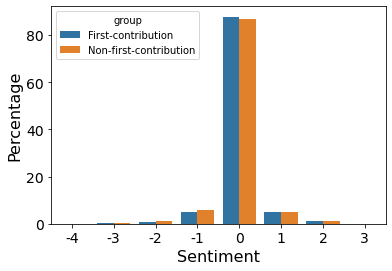

In [55]:
group1 = sentiment[sentiment['type']=='First-contribution']['sentiment'].value_counts()/len(sentiment[sentiment['type']=='First-contribution'])*100
group2 = sentiment[sentiment['type']!='First-contribution']['sentiment'].value_counts()/len(sentiment[sentiment['type']!='First-contribution'])*100
group1 = group1.reset_index().rename(columns={'index':'sentiment','sentiment':'First-contribution'})
group2 = group2.reset_index().rename(columns={'index':'sentiment','sentiment':'Non-first-contribution'})
p = sns.barplot(x='sentiment',y='value',hue='variable',data=group1.merge(group2, on='sentiment').melt(['sentiment']))
p.set_xlabel("Sentiment", fontsize=16)
p.set_ylabel("Percentage", fontsize=16)
p.legend(title='group', fontsize=10)
p.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('fig/R1/sentiment_R1_barplot.pdf',bbox_inches="tight")

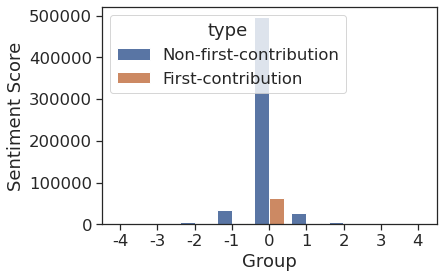

In [40]:
# sns.countplot(sentiment[sentiment['type']=='First-contribution']['sentiment'], color="r", label="First-contribution")
# sns.countplot(sentiment[sentiment['type']=='Non-first-contribution']['sentiment'], color="b", label="Non-first-contribution").set(xlim=(0))
sns.set(style="ticks", font_scale=1.5)
p = sns.countplot(x='sentiment',hue='type',data=sentiment)
# sns.countplot(x='sentiment', data = sentiment, hue='type')
p.set_xlabel("Group")
p.set_ylabel("Sentiment Score")
plt.savefig('fig/R1/sentiment_R1.pdf',bbox_inches="tight")

In [20]:
sentiment.head()

,Unnamed: 0,comment_id,base_repo_id,pull_request_id,pr_author,comment_author,body,created_at,sentiment,type,type2
0,0,5234151,6,1782580,8606,30,should also change to 'getnumberofrunningactio...,2013-07-17 01:28:32,0,Non-first-contribution,
1,1,12076712,6,3588556,1870960,32,'vector2' and the old 'point' is a class. plea...,2014-04-28 23:46:37,0,Non-first-contribution,
2,2,27455160,6,6889923,7543764,32,singleton in v2 branch is using ''' sharedxxx ...,2015-03-31 04:16:12,0,Non-first-contribution,
3,3,145033457,6,29064044,2249470,30,why do it like this? 'shadowcolor.a' is alread...,2017-10-17 06:00:16,0,First-contribution,
4,4,356375376,6,66133540,12490178,44353594,font resources for tests are missing,2019-12-11 02:20:55,0,Non-first-contribution,


In [25]:
sentiment[sentiment['type']=='First-contribution']['sentiment'].mean()

0.0019087664942322056

In [26]:
sentiment[sentiment['type']!='First-contribution']['sentiment'].mean()

-0.009113450914582396

In [239]:
sentiment[sentiment['type2']=='Interact']['sentiment'].value_counts()

 0    36991
-1     2217
 1     2168
 2      408
-2      358
-3       60
 3       43
Name: sentiment, dtype: int64

In [240]:
sentiment[sentiment['type2']=='Interact']['sentiment'].mean()

0.0

In [241]:
sentiment[sentiment['type2']!='Interact']['sentiment'].mean()

-0.00843816611631534

In [244]:
responsiveness['responsiveness'] = [int(math.e**i) for i in responsiveness['responsiveness']]

In [245]:
responsiveness[responsiveness['type']=='First-contribution']['responsiveness'].mean()

946346.1573041481

In [246]:
responsiveness[responsiveness['type']!='First-contribution']['responsiveness'].mean()

558416.198255178

In [248]:
responsiveness[responsiveness['type2']=='Interact']['responsiveness'].mean()

611712.7118475559

In [249]:
responsiveness[responsiveness['type2']!='Interact']['responsiveness'].mean()

601289.9610347935

<AxesSubplot:xlabel='type2', ylabel='count'>

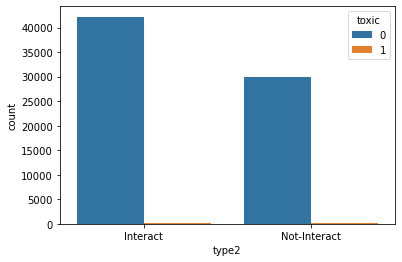

In [56]:
toxicity['type2'] = ''
toxicity.loc[toxicity['pull_request_id'].isin(interact_after_first_response['pull_request_id'].to_numpy()),'type2'] = 'Interact'
toxicity.loc[~toxicity['pull_request_id'].isin(interact_after_first_response['pull_request_id'].to_numpy()),'type2'] = 'Not-Interact'
sns.countplot(x ='type2',hue='toxic', data=toxicity[toxicity['type']=='First-contribution'])

In [40]:
sentiment['type2'] = ''
sentiment.loc[sentiment['pull_request_id'].isin(interact_after_first_response['pull_request_id'].to_numpy()),'type2'] = 'With Interaction'
sentiment.loc[~sentiment['pull_request_id'].isin(interact_after_first_response['pull_request_id'].to_numpy()),'type2'] = 'Without Interaction'

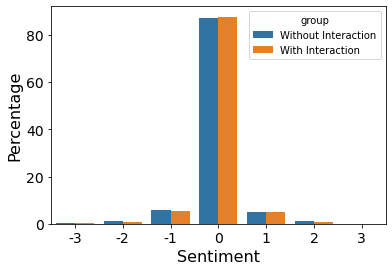

In [56]:
group1 = sentiment[sentiment['type2']=='With Interaction']['sentiment'].value_counts()/len(sentiment[sentiment['type2']=='With Interaction'])*100
group2 = sentiment[sentiment['type2']!='With Interaction']['sentiment'].value_counts()/len(sentiment[sentiment['type2']!='With Interaction'])*100
group1 = group1.reset_index().rename(columns={'index':'sentiment','sentiment':'With Interaction'})
group2 = group2.reset_index().rename(columns={'index':'sentiment','sentiment':'Without Interaction'})
p = sns.barplot(x='sentiment',y='value',hue='variable',data=group1.merge(group2, on='sentiment').melt(['sentiment']), hue_order=['Without Interaction','With Interaction'])
p.set_xlabel("Sentiment", fontsize=16)
p.set_ylabel("Percentage", fontsize=16)
p.legend(title='group', fontsize=10)
p.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('fig/R2/sentiment_R2_barplot.pdf',bbox_inches="tight")

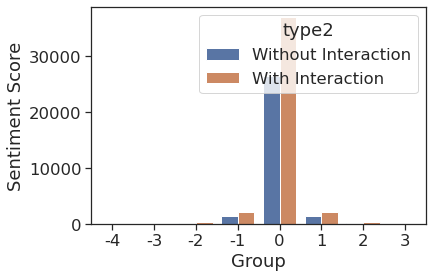

In [38]:
p = sns.countplot(x='sentiment',hue='type2',data=sentiment[sentiment['type']=='First-contribution'],hue_order=['Without Interaction','With Interaction'])
p.set_xlabel("Group")
p.set_ylabel("Sentiment Score")
plt.savefig('fig/R2/sentiment_R2.pdf',bbox_inches="tight")

In [176]:
sentiment[sentiment['type']=='First-contribution']['type2'].value_counts()

Interact        42245
Not-Interact    30029
Name: type2, dtype: int64

# Calculate Responsiveness

In [59]:
# sql = 'select fr.comment_id, fr.pull_request_id, pr.created_at as pr_created_at, fr.created_at as fr_created_at from {first_response} fr inner join {pull_requests} pr on fr.pull_request_id == pr.id'
# responsiveness = ks.sql(sql)
# responsiveness['fr_created_at'] =  ks.to_datetime(responsiveness['fr_created_at'], format='%Y-%m-%d %H:%M:%S')
# responsiveness['pr_created_at'] =  ks.to_datetime(responsiveness['pr_created_at'], format='%Y-%m-%d %H:%M:%S')
# responsiveness['responsiveness'] = (responsiveness['fr_created_at'] - responsiveness['pr_created_at'])
# responsiveness['type'] = ''
# responsiveness.loc[responsiveness['pull_request_id'].isin(first_contribution['id'].to_numpy()),'type'] = 'First-contribution'
# responsiveness.loc[~responsiveness['pull_request_id'].isin(first_contribution['id'].to_numpy()),'type'] = 'Non-first-contribution'
# responsiveness.to_csv(os.path.join(exper_dir,'responsiveness'))

In [19]:
responsiveness = ks.read_csv(os.path.join(exper_dir,'responsiveness/*.csv'))

In [20]:
responsiveness = responsiveness.to_pandas()

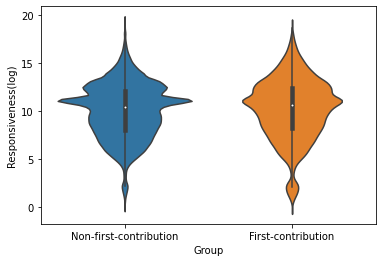

In [26]:
import math
responsiveness = responsiveness[responsiveness['responsiveness'] > 0]
responsiveness['responsiveness'] = [math.log(i) for i in responsiveness['responsiveness']]
p = sns.violinplot(y='responsiveness',x='type',data=responsiveness)
p.set_xlabel("Group")
p.set_ylabel("Responsiveness(log)")
plt.savefig('fig/R1/responsiveness_R1.pdf', bbox_inches="tight")

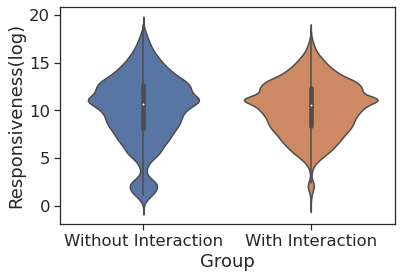

In [28]:
sns.set(style="ticks", font_scale=1.5)
responsiveness['type2'] = ''
responsiveness.loc[responsiveness['pull_request_id'].isin(interact_after_first_response['pull_request_id'].to_numpy()),'type2'] = 'With Interaction'
responsiveness.loc[~responsiveness['pull_request_id'].isin(interact_after_first_response['pull_request_id'].to_numpy()),'type2'] = 'Without Interaction'
# responsiveness['responsiveness'] = [math.log(i) for i in responsiveness['responsiveness']]
p = sns.violinplot(y='responsiveness',x='type2',data=responsiveness[responsiveness['type']=='First-contribution'])
p.set_xlabel("Group")
p.set_ylabel("Responsiveness(log)")
plt.savefig('fig/R2/responsiveness_R2.pdf', bbox_inches="tight")

In [21]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, chi2_contingency
# import pingouin as pg
# pg.compute_effsize(x, y, eftype='hedges')
from cliffsDelta import cliffsDelta
import researchpy

# Emotion

In [40]:
dir_emotion = ['anger','fear','joy','love','sadness','surprise']

emotion = {}

for emo in tqdm(dir_emotion):
    path_emo = os.path.join(exper_dir,os.path.join('emtk_prediction',emo))
    for i in os.listdir(path_emo):
        path_part = os.path.join(path_emo,i)
        if emo not in emotion:
            emotion[emo] = pd.read_csv(os.path.join(path_part,f'predictions_{emo}.csv'))
            emotion[emo] = emotion[emo].rename(columns={'id':'comment_id','predicted':emo})
        else:
            emotion[emo] = emotion[emo].append(pd.read_csv(os.path.join(path_part,f'predictions_{emo}.csv')).rename(columns={'id':'comment_id','predicted':emo}))
    

  0%|          | 0/6 [00:00<?, ?it/s]

In [41]:
dir_emotion = ['fear','joy','love','sadness','surprise']
emotion_temp = emotion
emotion = emotion['anger']
for emo in dir_emotion:
    emotion[emo] = emotion_temp[emo][emo]

In [42]:
# dir_emotion = ['fear','joy','love','sadness','surprise']
# emotion = pd.read_csv(os.path.join(os.path.join('emtk_prediction',exper_dir,'anger'),'predictions_anger.csv'))
# emotion = emotion.rename(columns={'id':'comment_id','predicted':'anger'})
# for emo in dir_emotion:
#     temp = pd.read_csv(os.path.join(os.path.join(exper_dir,emo),f'predictions_{emo}.csv'))
#     emotion[emo] = temp['predicted']

In [43]:
emotion_df = emotion.set_index('comment_id').join(toxicity.set_index('comment_id'), how='inner')[['type','anger','fear','joy','love','sadness','surprise']]

# Clean 

In [45]:
emotion_df = emotion_df.reset_index()
not_good = set(emotion_df[emotion_df.duplicated()]['comment_id'])
sentiment = sentiment[~sentiment['comment_id'].isin(not_good)]
emotion_df = emotion_df[~emotion_df['comment_id'].isin(not_good)]
toxicity = toxicity[~toxicity['comment_id'].isin(not_good)]
responsiveness = responsiveness[~responsiveness['comment_id'].isin(not_good)]
responsiveness = responsiveness[~responsiveness['comment_id'].duplicated()]

In [46]:
good = set(sentiment['comment_id'].to_numpy()) & set(emotion_df['comment_id'].to_numpy()) & set(toxicity['comment_id'].to_numpy()) & set(responsiveness['comment_id'].to_numpy())
good = set(list(good))
sentiment = sentiment[sentiment['comment_id'].isin(good)]
emotion_df = emotion_df[emotion_df['comment_id'].isin(good)]
toxicity = toxicity[toxicity['comment_id'].isin(good)]
responsiveness = responsiveness[responsiveness['comment_id'].isin(good)]

sentiment.to_csv(os.path.join(exper_dir,'clean_sentiment.csv'))
emotion_df.to_csv(os.path.join(exper_dir,'clean_emotion.csv'))
toxicity.to_csv(os.path.join(exper_dir,'clean_toxicity.csv'))
responsiveness.to_csv(os.path.join(exper_dir,'clean_responsiveness.csv'))

In [7]:
sentiment = pd.read_csv(os.path.join(exper_dir,'clean_sentiment.csv'))
emotion_df = pd.read_csv(os.path.join(exper_dir,'clean_emotion.csv'))
toxicity = pd.read_csv(os.path.join(exper_dir,'clean_toxicity.csv'))
responsiveness = pd.read_csv(os.path.join(exper_dir,'clean_responsiveness.csv'))

# Pulish Dataset

In [234]:
temp = sentiment[sentiment['type'] == 'First-contribution']
temp = temp[temp['pull_request_id'].isin(final_feature_df['pull_request_id'])]
final_sentiment = pd.concat([temp,sentiment[sentiment['type'] != 'First-contribution']])

temp = emotion_df[emotion_df['type'] == 'First-contribution']
temp = temp[temp['comment_id'].isin(final_feature_df['comment_id'])]
final_emotion = pd.concat([temp,emotion_df[emotion_df['type'] != 'First-contribution']])

temp = toxicity[toxicity['type'] == 'First-contribution']
temp = temp[temp['pull_request_id'].isin(final_feature_df['pull_request_id'])]
final_toxicity = pd.concat([temp,toxicity[toxicity['type'] != 'First-contribution']])

temp = responsiveness[responsiveness['type'] == 'First-contribution']
temp = temp[temp['pull_request_id'].isin(final_feature_df['pull_request_id'])]
final_responsiveness = pd.concat([temp,responsiveness[responsiveness['type'] != 'First-contribution']])

In [235]:
final_sentiment = final_sentiment.set_index('comment_id').drop(columns=['Unnamed: 0','type'])
final_emotion = final_emotion.set_index('comment_id').drop(columns=['Unnamed: 0','type'])
final_toxicity = final_toxicity.set_index('comment_id').drop(columns=['Unnamed: 0','type','base_repo_id','pull_request_id','pr_author','comment_author','body','created_at'])
final_responsiveness = final_responsiveness.set_index('comment_id').drop(columns=['Unnamed: 0','pull_request_id'])

In [236]:
dataset = final_sentiment.join(final_emotion, how="inner").join(final_toxicity, how="inner").join(final_responsiveness, how="inner")

In [237]:
dataset = dataset.reset_index()


In [251]:
d1 = dataset[['base_repo_id','pull_request_id','pr_author','pr_created_at','fr_created_at','comment_author','body','sentiment','toxic','anger','fear','joy','love','sadness','surprise','responsiveness','type']]
d2 = dataset[['base_repo_id','pull_request_id','pr_author','pr_created_at','fr_created_at','comment_author','body','sentiment','responsiveness','type','type2']]
name_mapping = {'pr_author':'pull_request_author','responsiveness':'responsiveness(log)','pr_created_at':'pull_request_created_at','fr_created_at':'first_response_created_at','body':'first_response_body','comment_author':'first_response_author','comment_id':'first_response_comment_id'}
d1 = d1.rename(columns=name_mapping)
d2 = d2.rename(columns=name_mapping)
d2 = d2[d2['type']=='First-contribution']
d2 = d2.drop(columns=['type'])
d2 = d2.rename(columns={'type2':'type'})
d1.to_csv('d1.csv')
d2.to_csv('d2.csv')

In [270]:
d2[d2['sentiment']<0]

,base_repo_id,pull_request_id,pull_request_author,pull_request_created_at,first_response_created_at,first_response_author,first_response_body,sentiment,responsiveness(log),type
34,5219,4299834,1599653,2014-07-31 09:07:20,2014-08-07 14:41:49,23695,"by processing samples in small batches, this c...",-1,13.345297,Interact
47,10070,1300955,220174,2013-03-31 13:21:18,2013-03-31 14:49:36,327536,you should remove the useless spaces in this line,-1,8.575085,Interact
61,21343,3347677,361732,2014-03-26 14:00:22,2014-03-26 15:18:18,111662,dumb -> dump,-1,8.450198,Not-Interact
65,23203,78179043,46848376,2020-04-24 13:33:55,2020-10-21 11:23:49,5820695,for newly added methods we should add argument...,-1,16.559198,Not-Interact
68,27245,66524552,8462082,2019-12-09 06:36:33,2019-12-09 16:38:32,75412,applying __attribute__((packed)) to an entire ...,-1,10.494574,Interact
...,...,...,...,...,...,...,...,...,...,...
71387,53564232,106530500,702052,2020-10-09 01:53:16,2020-10-09 21:42:39,680544,does this have to write tablerows? why not als...,-1,11.175535,Interact
71396,60452725,36106667,41960372,2018-03-09 14:24:42,2018-03-14 09:10:34,34857376,this setting is static for ipv4. restricting i...,-1,12.931571,Not-Interact
71406,74035828,71979644,38348082,2020-02-26 18:09:31,2020-03-02 16:24:50,50291865,'''suggestion // messagehasbeenposted automati...,-1,12.961535,Not-Interact
71408,86395247,34111772,1588933,2018-01-26 18:20:51,2018-01-26 18:33:32,38952,oops,-2,6.634633,Interact


In [252]:
d4 = final_feature_df[['toxic','anger','fear','joy','love', 'sadness', 'surprise', 'sentiment',
       'responsiveness', 'interaction', 'word_first_response', 'merged',
       'other_project_pr', 'other_same_language_pr', 'gh_account_duration', 'project_commit', 'project_pr',
       'language', 'pr_commit','future_contribution']]

In [254]:
d4.to_csv('d4.csv')

In [47]:
sentiment = sentiment.sort_values(by=['comment_id'])
emotion_df = emotion_df.sort_values(by=['comment_id'])
toxicity = toxicity.sort_values(by=['comment_id'])
responsiveness = responsiveness.sort_values(by=['comment_id'])

# Sample for qualitative

## RQ2 Qualitative

In [116]:
#start from 3
temp = sentiment[sentiment['type']=='First-contribution']
sample = temp[temp['sentiment'].isin([-4,-3,-2,-1])].sample(n=381,random_state=3)
sample = ks.from_pandas(sample)

In [118]:
temp[temp['sentiment'].isin([-4,-3,-2,-1])].shape

(4353, 12)

In [101]:
sql = '''SELECT p.url,pr.pullreq_id,s.body,s.sentiment  
from {sample} s inner join {pull_requests} pr on s.pull_request_id == pr.id
inner join {projects} p on s.base_repo_id == p.id'''
prepared_sample = ks.sql(sql)

In [102]:
prepared_sample = prepared_sample.to_pandas()

In [103]:
def prepare_url(url,pr_id):
    return url.replace('api.','').replace('repos/','')+'/pull/'+str(pr_id)

In [104]:
prepared_sample['link'] = list(map(prepare_url,prepared_sample['url'],prepared_sample['pullreq_id']))

In [105]:
prepared_sample.to_csv('qualitative_30_all_test.csv') 

## Sanity Check

In [57]:
sentiment.sample(n=384,random_state=3).to_csv('sanity_sentiment.csv') 

In [58]:
emotion_df.sample(n=384,random_state=3).to_csv('sanity_emotion.csv') 

In [59]:
toxicity.sample(n=384,random_state=3).to_csv('sanity_toxicity.csv') 

# RQ1

## H1.1

In [147]:
shapiro(sentiment['sentiment'])

/home/noppadol-a/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.48982036113739014, pvalue=0.0)

In [148]:
mannwhitneyu(sentiment[sentiment['type']=='Non-first-contribution']['sentiment'],sentiment[sentiment['type']!='Non-first-contribution']['sentiment'])

MannwhitneyuResult(statistic=20453758507.0, pvalue=1.3376355985290023e-12)

In [149]:
cliffsDelta(sentiment[sentiment['type']=='Non-first-contribution']['sentiment'],sentiment[sentiment['type']!='Non-first-contribution']['sentiment'])

(-0.009448655011467572, 'negligible')

## H1.2

In [154]:
shapiro(responsiveness['responsiveness'])

/home/noppadol-a/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.11131793260574341, pvalue=0.0)

In [155]:
mannwhitneyu(responsiveness[responsiveness['type']=='Non-first-contribution']['responsiveness'],responsiveness[responsiveness['type']!='Non-first-contribution']['responsiveness'])

MannwhitneyuResult(statistic=19758864951.5, pvalue=9.515177185834104e-80)

In [159]:
cliffsDelta(responsiveness[responsiveness['type']=='Non-first-contribution']['responsiveness'],responsiveness[responsiveness['type']!='Non-first-contribution']['responsiveness'])

(-0.04310036851407701, 'negligible')

## H1.3

In [54]:
# chisquare(toxicity[toxicity['type']=='Non-first-contribution']['toxic'])

In [55]:
# chisquare(toxicity[toxicity['type']!='Non-first-contribution']['toxic'])

In [304]:
obs = np.array([[570663,1506],[71257,179]])
chi2_contingency(obs)

(0.34138749872513724,
 0.5590294242132554,
 1,
 array([[5.70671024e+05, 1.49797588e+03],
        [7.12489759e+04, 1.87024122e+02]]))

In [57]:
toxicity[toxicity['type']=='Non-first-contribution']['toxic'].value_counts()

0    569902
1      1503
Name: toxic, dtype: int64

In [58]:
toxicity[toxicity['type']!='Non-first-contribution']['toxic'].value_counts()

0    72094
1      180
Name: toxic, dtype: int64

In [135]:
researchpy.crosstab(toxicity['type'], toxicity['toxic'], test = 'chi-square') 

(                         toxic              
 toxic                        0     1     All
 type                                        
 First-contribution       72094   180   72274
 Non-first-contribution  569902  1503  571405
 All                     641996  1683  643679,
                 Chi-square test  results
 0  Pearson Chi-square ( 1.0) =    0.4811
 1                    p-value =    0.4879
 2               Cramer's phi =    0.0009)

## H1.4

In [136]:
researchpy.crosstab(emotion_df['type'], emotion_df['fear'], test = 'chi-square') 

(                          fear               
 fear                        NO    YES     All
 type                                         
 First-contribution       66465   5809   72274
 Non-first-contribution  526694  44711  571405
 All                     593159  50520  643679,
                 Chi-square test  results
 0  Pearson Chi-square ( 1.0) =    4.0140
 1                    p-value =    0.0451
 2               Cramer's phi =    0.0025)

In [321]:
# temp = emotion_df[emotion_df['type']=='First-contribution']
# temp = temp[temp['comment_id'].isin(final_feature_df['comment_id'])]
# temp =pd.concat([temp,emotion_df[emotion_df['type']!='First-contribution']])
# researchpy.crosstab(temp['type'], temp['fear'], test = 'chi-square') 

In [137]:
researchpy.crosstab(emotion_df['type'], emotion_df['anger'], test = 'chi-square') 

(                         anger              
 anger                       NO   YES     All
 type                                        
 First-contribution       71302   972   72274
 Non-first-contribution  562839  8566  571405
 All                     634141  9538  643679,
                 Chi-square test  results
 0  Pearson Chi-square ( 1.0) =   10.4542
 1                    p-value =    0.0012
 2               Cramer's phi =    0.0040)

In [138]:
researchpy.crosstab(emotion_df['type'], emotion_df['joy'], test = 'chi-square') 

(                           joy               
 joy                         NO    YES     All
 type                                         
 First-contribution       67112   5162   72274
 Non-first-contribution  534623  36782  571405
 All                     601735  41944  643679,
                 Chi-square test  results
 0  Pearson Chi-square ( 1.0) =   52.3699
 1                    p-value =    0.0000
 2               Cramer's phi =    0.0090)

In [139]:
researchpy.crosstab(emotion_df['type'], emotion_df['love'], test = 'chi-square') 

(                          love               
 love                        NO    YES     All
 type                                         
 First-contribution       70849   1425   72274
 Non-first-contribution  561159  10246  571405
 All                     632008  11671  643679,
                 Chi-square test  results
 0  Pearson Chi-square ( 1.0) =   11.4877
 1                    p-value =    0.0007
 2               Cramer's phi =    0.0042)

In [140]:
researchpy.crosstab(emotion_df['type'], emotion_df['sadness'], test = 'chi-square') 

(                       sadness               
 sadness                     NO    YES     All
 type                                         
 First-contribution       70268   2006   72274
 Non-first-contribution  554687  16718  571405
 All                     624955  18724  643679,
                 Chi-square test  results
 0  Pearson Chi-square ( 1.0) =    5.1264
 1                    p-value =    0.0236
 2               Cramer's phi =    0.0028)

In [141]:
researchpy.crosstab(emotion_df['type'], emotion_df['surprise'], test = 'chi-square') 

(                       surprise                
 surprise                     NO     YES     All
 type                                           
 First-contribution        62607    9667   72274
 Non-first-contribution   476001   95404  571405
 All                      538608  105071  643679,
                 Chi-square test   results
 0  Pearson Chi-square ( 1.0) =   518.0261
 1                    p-value =     0.0000
 2               Cramer's phi =     0.0284)

# RQ2

## H2.1

In [258]:
h2_sentiment = sentiment[sentiment['type']=='First-contribution']

In [259]:
shapiro(h2_sentiment['sentiment'])

ShapiroResult(statistic=0.47099536657333374, pvalue=0.0)

In [260]:
mannwhitneyu(h2_sentiment[h2_sentiment['type2']=='Interact']['sentiment'],h2_sentiment[h2_sentiment['type2']!='Interact']['sentiment'])

MannwhitneyuResult(statistic=631811067.5, pvalue=0.11463329981018108)

In [261]:
cliffsDelta(h2_sentiment[h2_sentiment['type2']=='Interact']['sentiment'],h2_sentiment[h2_sentiment['type2']!='Interact']['sentiment'])

(-0.003904356928082709, 'negligible')

## H2.2

In [262]:
h2_responsiveness = responsiveness[responsiveness['type']=='First-contribution']

In [263]:
shapiro(h2_responsiveness['responsiveness'])

ShapiroResult(statistic=0.1748577356338501, pvalue=0.0)

In [264]:
mannwhitneyu(h2_responsiveness[h2_responsiveness['type2']=='Interact']['responsiveness'],h2_responsiveness[h2_responsiveness['type2']!='Interact']['responsiveness'])

MannwhitneyuResult(statistic=630616845.5, pvalue=0.18418798137698345)

In [265]:
cliffsDelta(h2_responsiveness[h2_responsiveness['type2']=='Interact']['responsiveness'],h2_responsiveness[h2_responsiveness['type2']!='Interact']['responsiveness'])

(-0.005787133904066327, 'negligible')

# RQ3

# Feature Extraction

## Merge the sentiment responsiveness toxicity and emotion

In [118]:
toxicity_temp = toxicity[['comment_id','base_repo_id','pull_request_id','pr_author','comment_author','body','created_at','toxic','type','type2']]
toxicity_temp = toxicity_temp[toxicity_temp['type']=='First-contribution']
toxicity_temp = toxicity_temp.set_index('comment_id')

In [119]:
emotion_df_temp = emotion_df[['comment_id','anger','fear','joy','love','sadness','surprise']]
emotion_df_temp = emotion_df_temp.set_index('comment_id')

In [120]:
sentiment_temp =sentiment[['comment_id','sentiment']]
sentiment_temp = sentiment_temp.set_index('comment_id')

In [121]:
responsiveness['fr_created_at'] =  pd.to_datetime(responsiveness['fr_created_at'], format='%Y-%m-%d %H:%M:%S')
responsiveness['pr_created_at'] =  pd.to_datetime(responsiveness['pr_created_at'], format='%Y-%m-%d %H:%M:%S')
responsiveness['responsiveness'] = (responsiveness['fr_created_at'] - responsiveness['pr_created_at'])
responsiveness['responsiveness'] = [i.total_seconds() for i in responsiveness['responsiveness']]
responsiveness_temp = responsiveness[['comment_id','responsiveness']]
responsiveness_temp = responsiveness_temp.set_index('comment_id')

In [122]:
feature_df = toxicity_temp.join(emotion_df_temp, how="inner").join(sentiment_temp, how="inner").join(responsiveness_temp, how="inner")

## Interaction

In [123]:
sql = 'select pull_request_id, count(body) from {pull_request_comments} group by pull_request_id'
interaction = ks.sql(sql)
interaction = interaction.to_pandas()
interaction = interaction.set_index('pull_request_id')
interaction = interaction.rename(columns={'count(body)': 'interaction'})

In [124]:
feature_df = feature_df.reset_index().set_index('pull_request_id')

In [125]:
feature_df = feature_df.join(interaction, how="inner")

## Words in the First Response

In [126]:
from nltk.tokenize import word_tokenize

In [127]:
feature_df['word_first_response'] = feature_df['body'].map(lambda x: len(word_tokenize(str(x))))

## result PR

In [117]:
header_list = ["id","pull_request_id","created_at","action","actor_id"]
pull_request_history = ks.read_csv(os.path.join(data_path,'pull_request_history.csv'), header=None, names=header_list)

In [129]:
# finished_action = ['closed','merged']
# sql = '''
#     select * from {pull_request_history} where action in {finished_action}
# '''
# pull_request_history = ks.sql(sql)

In [130]:
feature_df = feature_df.reset_index()

In [131]:
# pull_request_history = pull_request_history.sort_values(by = ['created_at']) 
# pull_request_history = pull_request_history.drop_duplicates(subset=['pull_request_id'], keep='last')
# pull_request_history = pull_request_history[['pull_request_id','action']]
# pull_request_history = pull_request_history.set_index('pull_request_id')
# feature_df = feature_df.set_index('pull_request_id')
# feature_df = pull_request_history.join(ks.from_pandas(feature_df), how="inner")
# feature_df = feature_df.to_pandas()

In [132]:
pull_request_history = pull_request_history[pull_request_history['action']=='merged']
success_pr = pull_request_history['pull_request_id'].unique()
success_pr = set(success_pr.to_numpy())
feature_df['action'] = feature_df['pull_request_id'].map(lambda x: 'merged' if x in success_pr else 'closed')

In [133]:
feature_df = feature_df.rename(columns={'action':'merged'})
feature_df['merged'] = feature_df['merged'].map({'merged':True,'closed':False})
feature_df = feature_df.set_index('pull_request_id')

##  pull request created in other project

In [134]:
feature_df = feature_df.reset_index()
sub_sql = '''
    (select f.pull_request_id,f.pr_author,f.base_repo_id,pr.created_at from 
    {feature_df} f inner join {pull_requests} pr on f.pull_request_id = pr.id)
'''
sql = '''
    select f.pull_request_id, count(distinct(id)) from 
    %s f inner join {pull_requests} pr on f.pr_author = pr.actor_id
    where f.base_repo_id <> pr.base_repo_id and f.created_at > pr.created_at
    group by f.pull_request_id
'''%(sub_sql)
previous_pr = ks.sql(sql)
previous_pr = previous_pr.set_index('pull_request_id')
feature_df = feature_df.set_index('pull_request_id')
feature_df = ks.from_pandas(feature_df).join(previous_pr, how="left")
feature_df = feature_df.to_pandas()

In [138]:
feature_df = feature_df.rename(columns={'count(DISTINCT id)':'other_project_pr'})
feature_df['other_project_pr'] = feature_df['other_project_pr'].fillna(value=0)

##  pull request created in other project using same langauge

In [190]:
feature_df = feature_df.reset_index()
sub_sub_sql = '''
    (select f.pull_request_id,f.pr_author,f.base_repo_id,pr.created_at from 
    {feature_df} f inner join {pull_requests} pr on f.pull_request_id = pr.id)
'''
sub_sql1 = '''
    (select * from 
    %s f inner join {inspect_project} p on f.base_repo_id = p.id)
'''%(sub_sub_sql)
sub_sql2 = '''
    (select base_repo_id,pr.id,actor_id,created_at,pullreq_id,p.language from 
    {pull_requests} pr inner join {inspect_project} p on pr.base_repo_id = p.id)
'''
sql ='''
    select f.pull_request_id, count(distinct(pr.id)) from 
    %s f inner join %s pr on f.pr_author = pr.actor_id
    where f.base_repo_id <> pr.base_repo_id and f.created_at > pr.created_at and f.language == pr.language
    group by f.pull_request_id
'''%(sub_sql1,sub_sql2)
previous_same_language_pr = ks.sql(sql)
previous_same_language_pr = previous_same_language_pr.set_index('pull_request_id')
feature_df = feature_df.set_index('pull_request_id')
feature_df = ks.from_pandas(feature_df).join(previous_same_language_pr, how="left")
feature_df = feature_df.to_pandas()
feature_df = feature_df.rename(columns={'count(DISTINCT id)':'other_same_language_pr'})
feature_df['other_same_language_pr'] = feature_df['other_same_language_pr'].fillna(value=0)

##  How long the Github Account have been created (INT)

In [119]:
header_list = ["id","login","company","created_at","type","fake","deleted","long","lat","country_code","state","city","location"]
users = ks.read_csv(os.path.join(data_path,'users.csv'), header=None, names=header_list)
users = users[['created_at','id']]

In [240]:
feature_df = feature_df.reset_index()
sub_sql = '''
    (select f.pull_request_id,f.pr_author,f.base_repo_id,pr.created_at from 
    {feature_df} f inner join {pull_requests} pr on f.pull_request_id = pr.id)
'''
sql ='''
    select f.pull_request_id,f.created_at as pr_created_at,u.created_at as u_created_at from
    %s f inner join {users} u on f.pr_author = u.id 
'''%(sub_sql)
gh_account_duration = ks.sql(sql)
gh_account_duration = gh_account_duration.to_pandas()

In [241]:
gh_account_duration['pr_created_at'] =  pd.to_datetime(gh_account_duration['pr_created_at'], format='%Y-%m-%d %H:%M:%S')
gh_account_duration['u_created_at'] =  pd.to_datetime(gh_account_duration['u_created_at'], format='%Y-%m-%d %H:%M:%S')
gh_account_duration['gh_account_duration'] = (gh_account_duration['pr_created_at'] - gh_account_duration['u_created_at'])
gh_account_duration['gh_account_duration'] = gh_account_duration['gh_account_duration'].map(lambda x: 0 if x.total_seconds()<0 else x.total_seconds())
gh_account_duration = gh_account_duration.set_index('pull_request_id')
feature_df = feature_df.set_index('pull_request_id')
feature_df = feature_df.join(gh_account_duration, how="inner")


## Number of Commit of project at the time of pull request created 

In [245]:
header_list = ["id","sha","author_id","committer_id","project_id","created_at"]
commits = ks.read_csv(os.path.join(data_path,'commits.csv'), header=None, names=header_list)

In [247]:
feature_df = feature_df.reset_index()
sub_sql = '''
    (select f.pull_request_id,f.pr_author,f.base_repo_id,pr.created_at from 
    {feature_df} f inner join {pull_requests} pr on f.pull_request_id = pr.id)
'''
sql ='''
    select f.pull_request_id,count(distinct c.id) as project_commit from
    %s f inner join {commits} c on f.base_repo_id = c.project_id  where f.created_at>c.created_at
    group by f.pull_request_id
'''%(sub_sql)
project_commit = ks.sql(sql)
project_commit = project_commit.to_pandas()
project_commit = project_commit.set_index('pull_request_id')
feature_df = feature_df.set_index('pull_request_id')
feature_df = feature_df.join(project_commit, how="left")
feature_df['project_commit'] = feature_df['project_commit'].fillna(value=0)

## Number of Pull request at the time of pull request created

In [248]:
feature_df = feature_df.reset_index()
sub_sql = '''
    (select f.pull_request_id,f.pr_author,f.base_repo_id,pr.created_at from 
    {feature_df} f inner join {pull_requests} pr on f.pull_request_id = pr.id)
'''
sql = '''
    select f.pull_request_id, count(distinct(pr.id)) as project_pr from 
    %s f inner join {pull_requests} pr on f.base_repo_id = pr.base_repo_id
    where f.created_at > pr.created_at
    group by f.pull_request_id
'''%(sub_sql)
project_pr = ks.sql(sql)
project_pr = project_pr.to_pandas()
project_pr = project_pr.set_index('pull_request_id')
feature_df = feature_df.set_index('pull_request_id')
feature_df = feature_df.join(project_pr, how="left")
feature_df['project_pr'] = feature_df['project_pr'].fillna(value=0)

## Programming Languages

In [249]:
feature_df = feature_df.reset_index()
sql = '''
    select f.pull_request_id,p.language from 
    {feature_df} f inner join {inspect_project} p on f.base_repo_id = p.id
'''
language = ks.sql(sql)
language = language.to_pandas()
language = language.set_index('pull_request_id')
feature_df = feature_df.set_index('pull_request_id')
feature_df = feature_df.join(language, how="inner")

## Number of Commit in pr

In [250]:
header_list = ["pull_request_id","commit_id"]
pull_request_commits = ks.read_csv(os.path.join(data_path,'pull_request_commits.csv'), header=None, names=header_list)

In [251]:
feature_df = feature_df.reset_index()
sql = '''
    select pull_request_id, count(commit_id) as pr_commit from
    {pull_request_commits} group by pull_request_id
'''
pr_commit = ks.sql(sql)
pr_commit = pr_commit.set_index('pull_request_id')
feature_df = feature_df.set_index('pull_request_id')
feature_df = ks.from_pandas(feature_df).join(pr_commit, how="left")
feature_df = feature_df.to_pandas()
feature_df['pr_commit'] = feature_df['pr_commit'].fillna(value=0)

## Continue contributed or not

In [298]:
# feature_df = feature_df.reset_index()
# sql = '''
#     select f.pull_request_id,pr.created_at as pr_created_at from 
#     {feature_df} f inner join {pull_requests} pr on f.pull_request_id = pr.id
# '''
# pr_created_time=ks.sql(sql)
# pr_created_time = pr_created_time.to_pandas()
# feature_df = feature_df.set_index('pull_request_id')
# pr_created_time = pr_created_time.set_index('pull_request_id')
# feature_df = feature_df.join(pr_created_time, how="inner")

In [270]:
feature_df = feature_df.drop_duplicates(subset = ['comment_id'],keep='last')

In [299]:
feature_df.head(1)

,pull_request_id,comment_id,base_repo_id,pr_author,comment_author,body,created_at,toxic,type,type2,...,merged,other_project_pr,other_same_language_pr,pr_created_at,u_created_at,gh_account_duration,project_commit,project_pr,language,pr_commit
0,203455,743369,634,178630,859,this is useless. the base class can be found b...,2012-04-27 05:54:55,0,First-contribution,Not-Interact,...,False,1.0,1.0,2012-02-01 22:06:45,2010-02-20 14:22:31,61458254.0,1971.0,2263.0,PHP,1.0


In [302]:
# feature_df = feature_df.reset_index()
sql = '''
    select pull_request_id,count(distinct nfc.id) as future_contribution, min(nfc.created_at) as next_contribution_created_at
    from {feature_df} f inner join {non_first_contribution} nfc on f.pr_author = nfc.actor_id
    where f.base_repo_id == nfc.base_repo_id and f.pr_created_at < nfc.created_at
    group by pull_request_id
'''
future_contribution = ks.sql(sql)
future_contribution = future_contribution.to_pandas()
feature_df = feature_df.set_index('pull_request_id')
future_contribution = future_contribution.set_index('pull_request_id')
feature_df = feature_df.join(future_contribution, how="left")
feature_df['future_contribution'] = feature_df['future_contribution'].fillna(value=0)
feature_df['next_contribution_created_at'] = feature_df['next_contribution_created_at'].fillna(value=0)

In [318]:
calculated_waiting_duration = feature_df[feature_df['next_contribution_created_at']!=0]
calculated_waiting_duration['pr_created_at'] =  pd.to_datetime(calculated_waiting_duration['pr_created_at'], format='%Y-%m-%d %H:%M:%S')
calculated_waiting_duration['next_contribution_created_at'] =  pd.to_datetime(calculated_waiting_duration['next_contribution_created_at'], format='%Y-%m-%d %H:%M:%S')
calculated_waiting_duration['duration_next_contribution'] = (calculated_waiting_duration['next_contribution_created_at'] - calculated_waiting_duration['pr_created_at'])
calculated_waiting_duration['duration_next_contribution'] = calculated_waiting_duration['duration_next_contribution'].map(lambda x: 0 if x.total_seconds()<0 else x.total_seconds())
calculated_waiting_duration = calculated_waiting_duration[['duration_next_contribution']]

<ipython-input-318-510d010bd8f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calculated_waiting_duration['pr_created_at'] =  pd.to_datetime(calculated_waiting_duration['pr_created_at'], format='%Y-%m-%d %H:%M:%S')
<ipython-input-318-510d010bd8f1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calculated_waiting_duration['next_contribution_created_at'] =  pd.to_datetime(calculated_waiting_duration['next_contribution_created_at'], format='%Y-%m-%d %H:%M:%S')
<ipython-input-318-510d010bd8f1>:4: SettingW

In [320]:
feature_df = feature_df.join(calculated_waiting_duration, how="left")
feature_df['duration_next_contribution'] = feature_df['duration_next_contribution'].fillna(value=0)

In [386]:
max_duration_next_contribution = feature_df['duration_next_contribution'].max()

In [337]:
newest_pr = pd.to_datetime(pull_requests['created_at'].max(), format='%Y-%m-%d %H:%M:%S')

In [342]:
feature_df['duration_until_newest_pr'] = feature_df['pr_created_at'].map(lambda x: (newest_pr-x).total_seconds())

In [389]:
not_valid_assumption_future_contrib = feature_df[feature_df['duration_until_newest_pr']>max_duration_next_contribution]
not_valid_assumption_future_contrib = not_valid_assumption_future_contrib[not_valid_assumption_future_contrib['future_contribution']==0]
not_valid_assumption_future_contrib = set(not_valid_assumption_future_contrib.reset_index()['pull_request_id'])

In [392]:
feature_df = feature_df.reset_index()
final_feature_df = feature_df[~feature_df['pull_request_id'].isin(not_valid_assumption_future_contrib)]

In [395]:
final_feature_df.to_csv(os.path.join(exper_dir,'final_feature_df.csv'))

## preprocess data

In [142]:
final_feature_df.shape

(71436, 35)

In [140]:
final_feature_df = pd.read_csv(os.path.join(exper_dir,'final_feature_df.csv'))
# final_feature_df = pd.read_csv(os.path.join(exper_dir,'final_feature_df.csv'))
# final_feature_df2 = pd.read_csv(os.path.join(exper_dir,'final_feature_df_non_response.csv'))
# final_feature_df = pd.concat([final_feature_df,final_feature_df2])

In [100]:
df_x = final_feature_df[['toxic','anger','fear','joy','love', 'sadness', 'surprise', 'sentiment',
       'responsiveness', 'interaction', 'word_first_response', 'merged',
       'other_project_pr', 'other_same_language_pr', 'gh_account_duration', 'project_commit', 'project_pr',
       'language', 'pr_commit','future_contribution']]


In [141]:
final_feature_df

,Unnamed: 0,pull_request_id,comment_id,base_repo_id,pr_author,comment_author,body,created_at,toxic,type,...,u_created_at,gh_account_duration,project_commit,project_pr,language,pr_commit,future_contribution,next_contribution_created_at,duration_next_contribution,duration_until_newest_pr
0,5,1566059,5277842,3137,127448,14531,could you remove extra spaces near 'class=' ?,2013-07-18 18:10:49,0,First-contribution,...,2009-02-19 23:28:39,135536092.0,3055.0,1504.0,JavaScript,5.0,2.0,2013-06-11 21:03:02,362371.0,244449680.0
1,7,2116265,6502411,4751,1854341,22249,this method always just returns?,2013-09-21 10:21:40,0,First-contribution,...,2013-04-26 08:19:12,12710000.0,12633.0,353.0,Java,4.0,0.0,0,0.0,235397539.0
2,8,2398219,7467055,1593177,45582,859,shoudln't you return ''unknown error ($code)''...,2013-11-06 14:43:55,0,First-contribution,...,2009-04-25 03:05:40,143119669.0,129.0,91.0,PHP,5.0,0.0,0,0.0,231323482.0
3,9,2399118,7489525,1920336,2213792,1433320,will the links be added to the api documentati...,2013-11-07 07:22:09,0,First-contribution,...,2013-05-22 10:20:56,14537118.0,1614.0,705.0,Java,2.0,8.0,2013-11-13 15:49:31,602597.0,231316717.0
4,10,2740864,8720200,3140649,495254,1721717,we should probably try to have similar gpl hea...,2014-01-08 09:41:55,0,First-contribution,...,2011-01-07 06:52:44,94789812.0,95.0,76.0,C++,20.0,6.0,2014-01-28 08:18:18,1724122.0,225898915.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71431,72269,122367359,574412546,157406382,49259846,56763017,"as soon as you preserve values of power, scale...",2021-02-11 11:01:53,0,First-contribution,...,2012-03-09 00:59:21,281636386.0,11959.0,3115.0,C++,2.0,0.0,0,0.0,2180744.0
71432,72270,122726361,575635901,634,49831930,190340,'''suggestion * add support for 'x-ses-source-...,2021-02-13 07:48:12,0,First-contribution,...,2010-04-11 15:24:28,342181762.0,39368.0,21946.0,PHP,3.0,1.0,2021-02-14 22:53:04,161954.0,1890661.0
71433,72271,123408824,579213902,131467158,56618464,37786045,gyeolgug outputvieweseoyi culryeog mungureul w...,2021-02-19 14:13:14,0,First-contribution,...,2019-04-05 10:10:13,59175976.0,2621.0,227.0,Java,67.0,1.0,2021-02-25 10:48:31,615122.0,1436902.0
71434,72272,124698382,585243631,55664673,63953498,12042841,'''suggestion ''',2021-03-02 04:30:42,0,First-contribution,...,2020-09-18 23:11:06,14163261.0,27895.0,7525.0,C,11.0,0.0,0,0.0,437964.0


In [101]:
emotion = ['anger','fear','joy','love', 'sadness','surprise']
for e in emotion:
    df_x[e] = df_x[e].map(lambda x: 1 if x=='YES' else 0)

<ipython-input-101-bbc4a6a9c8c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x[e] = df_x[e].map(lambda x: 1 if x=='YES' else 0)


In [102]:
df_x['merged'] = df_x['merged'].map(lambda x: 1 if x else 0)

<ipython-input-102-44868a44a27f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['merged'] = df_x['merged'].map(lambda x: 1 if x else 0)


In [103]:
df_x['future_contribution'] = df_x['future_contribution'].map(lambda x: 1 if x>0 else 0)

<ipython-input-103-6e84456120e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['future_contribution'] = df_x['future_contribution'].map(lambda x: 1 if x>0 else 0)


In [104]:
# from sklearn.preprocessing import OneHotEncoder
# df_x = df_x.reset_index().drop(columns=['index'])
# enc = OneHotEncoder(handle_unknown='ignore')
# enc_df = pd.DataFrame(enc.fit_transform(df_x[['language']]).toarray())
# df_x = df_x.join(enc_df)

In [105]:
programming_langauge = df_x['language'].unique()
programming_langauge_df = pd.DataFrame(programming_langauge, columns=['language'])
dum_df = pd.get_dummies(programming_langauge_df, columns=["language"], prefix=["language"] )
programming_langauge_df = programming_langauge_df.join(dum_df)
df_x = pd.merge(df_x, programming_langauge_df, how='inner', on='language')
df_x.drop(columns=['language'],inplace=True)

In [106]:
df_y = list(df_x['future_contribution'])
df_x.drop(columns=['future_contribution'],inplace=True)

## train and test

In [223]:
# import autosklearn.classification
# import sklearn.model_selection
# import sklearn.datasets
# import sklearn.metrics

# if __name__ == "__main__":
#     X, y = sklearn.datasets.load_digits(return_X_y=True)
#     X_train, X_test, y_train, y_test = \
#         sklearn.model_selection.train_test_split(df_x, df_y, random_state=1)
#     automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=60*60,n_jobs=40,memory_limit=150*1024)
#     automl.fit(X_train, y_train)
#     y_hat = automl.predict(X_test)
#     print("AUROC score", sklearn.metrics.roc_auc_score(y_test, automl.predict_proba(X_test)[:,1]))

In [224]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score


In [214]:
df_x.corr()['future_contribution'].sort_values().round(3)

gh_account_duration      -0.084
project_pr               -0.053
language_Ruby            -0.052
language_JavaScript      -0.035
project_commit           -0.011
language_PHP             -0.010
sentiment                -0.002
love                     -0.001
responsiveness            0.000
toxic                     0.003
sadness                   0.005
anger                     0.005
joy                       0.007
fear                      0.010
language_C                0.013
surprise                  0.018
language_Python           0.020
other_project_pr          0.020
pr_commit                 0.023
other_same_language_pr    0.023
word_first_response       0.029
language_C++              0.029
language_Java             0.038
merged                    0.049
interaction               0.050
future_contribution       1.000
Name: future_contribution, dtype: float64

In [225]:
df_x.corr()['future_contribution'].sort_values().round(3)

language_Ruby            -0.102
gh_account_duration      -0.079
project_pr               -0.065
language_PHP             -0.026
responsiveness           -0.016
love                     -0.014
word_first_response      -0.012
project_commit           -0.008
joy                      -0.007
sentiment                -0.005
language_JavaScript      -0.004
sadness                  -0.003
fear                     -0.000
anger                     0.002
toxic                     0.002
language_C                0.009
surprise                  0.009
language_Python           0.012
other_project_pr          0.017
other_same_language_pr    0.022
language_C++              0.049
language_Java             0.049
pr_commit                 0.070
merged                    0.071
interaction               0.082
future_contribution       1.000
Name: future_contribution, dtype: float64

In [188]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import mutual_info_classif

# df_x_new = SelectKBest(mutual_info_classif, k=5).fit_transform(df_x, df_y)


In [189]:
LR = LogisticRegression(n_jobs=-1)
RF = RandomForestClassifier(n_jobs=-1)
SVM = svm.SVC()
scores_LR = cross_val_score(LR, df_x, df_y, cv=10,scoring= 'roc_auc')
scores_RF = cross_val_score(RF, df_x, df_y, cv=10,scoring= 'roc_auc')
# scores_SVM = cross_val_score(SVM, df_x, df_y, cv=10,scoring= 'roc_auc')

/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1344, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn

/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1344, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn

/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    X, y = self._validate_data(X, y, multi_output=True,
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", 

/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    X, y = self._validate_data(X, y, multi_output=True,
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/noppadol-a/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", 

In [191]:
scores_LR

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [192]:
scores_RF.mean()

nan

In [24]:
# scores_SVM

In [58]:
from sklearn.model_selection import RandomizedSearchCV
if __name__ == "__main__":
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    rf = RandomForestClassifier(n_jobs = -1)
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(df_x, df_y)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/noppadol-a/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [59]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': False}

In [83]:
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import f1_score
# clf = RandomForestClassifier().fit(df_x, df_y)
# roc_auc_score(df_y, clf.predict_proba(df_x)[:, 1])
# f1_score(df_y, clf.predict(df_x), average='weighted')

## Data with no response

## Merge the sentiment responsiveness toxicity and emotion

In [21]:
first_contribution = ks.read_csv(os.path.join(exper_dir,'first_contribution/*.csv'))
non_first_contribution = ks.read_csv(os.path.join(exper_dir,'non_first_contribution/*.csv'))

In [9]:
response_data = set(final_feature_df['pull_request_id'])

In [13]:
feature_df = first_contribution.to_pandas().rename(columns={'id':'pull_request_id','actor_id':'pr_author'})

In [16]:
feature_df.shape

(292882, 5)

## result PR

In [17]:
header_list = ["id","pull_request_id","created_at","action","actor_id"]
pull_request_history = ks.read_csv(os.path.join(data_path,'pull_request_history.csv'), header=None, names=header_list)
pull_request_history = pull_request_history[pull_request_history['action']=='merged']
success_pr = pull_request_history['pull_request_id'].unique()
success_pr = set(success_pr.to_numpy())
feature_df['action'] = feature_df['pull_request_id'].map(lambda x: 'merged' if x in success_pr else 'closed')
feature_df = feature_df.rename(columns={'action':'merged'})
feature_df['merged'] = feature_df['merged'].map({'merged':True,'closed':False})
feature_df = feature_df.set_index('pull_request_id')

##  pull request created in other project

In [19]:
feature_df = feature_df.reset_index()
sub_sql = '''
    (select f.pull_request_id,f.pr_author,f.base_repo_id,pr.created_at from 
    {feature_df} f inner join {pull_requests} pr on f.pull_request_id = pr.id)
'''
sql = '''
    select f.pull_request_id, count(distinct(id)) from 
    %s f inner join {pull_requests} pr on f.pr_author = pr.actor_id
    where f.base_repo_id <> pr.base_repo_id and f.created_at > pr.created_at
    group by f.pull_request_id
'''%(sub_sql)
previous_pr = ks.sql(sql)
previous_pr = previous_pr.set_index('pull_request_id')
feature_df = feature_df.set_index('pull_request_id')
feature_df = ks.from_pandas(feature_df).join(previous_pr, how="left")
feature_df = feature_df.to_pandas()
feature_df = feature_df.rename(columns={'count(DISTINCT id)':'other_project_pr'})
feature_df['other_project_pr'] = feature_df['other_project_pr'].fillna(value=0)

##  pull request created in other project using same langauge

In [22]:
inspect_project = ks.read_csv(os.path.join(exper_dir,'project/*.csv'))

In [23]:
feature_df = feature_df.reset_index()
sub_sub_sql = '''
    (select f.pull_request_id,f.pr_author,f.base_repo_id,pr.created_at from 
    {feature_df} f inner join {pull_requests} pr on f.pull_request_id = pr.id)
'''
sub_sql1 = '''
    (select * from 
    %s f inner join {inspect_project} p on f.base_repo_id = p.id)
'''%(sub_sub_sql)
sub_sql2 = '''
    (select base_repo_id,pr.id,actor_id,created_at,pullreq_id,p.language from 
    {pull_requests} pr inner join {inspect_project} p on pr.base_repo_id = p.id)
'''
sql ='''
    select f.pull_request_id, count(distinct(pr.id)) from 
    %s f inner join %s pr on f.pr_author = pr.actor_id
    where f.base_repo_id <> pr.base_repo_id and f.created_at > pr.created_at and f.language == pr.language
    group by f.pull_request_id
'''%(sub_sql1,sub_sql2)
previous_same_language_pr = ks.sql(sql)
previous_same_language_pr = previous_same_language_pr.set_index('pull_request_id')
feature_df = feature_df.set_index('pull_request_id')
feature_df = ks.from_pandas(feature_df).join(previous_same_language_pr, how="left")
feature_df = feature_df.to_pandas()
feature_df = feature_df.rename(columns={'count(DISTINCT id)':'other_same_language_pr'})
feature_df['other_same_language_pr'] = feature_df['other_same_language_pr'].fillna(value=0)

##  How long the Github Account have been created (INT)

In [24]:
header_list = ["id","login","company","created_at","type","fake","deleted","long","lat","country_code","state","city","location"]
users = ks.read_csv(os.path.join(data_path,'users.csv'), header=None, names=header_list)
users = users[['created_at','id']]

feature_df = feature_df.reset_index()
sub_sql = '''
    (select f.pull_request_id,f.pr_author,f.base_repo_id,pr.created_at from 
    {feature_df} f inner join {pull_requests} pr on f.pull_request_id = pr.id)
'''
sql ='''
    select f.pull_request_id,f.created_at as pr_created_at,u.created_at as u_created_at from
    %s f inner join {users} u on f.pr_author = u.id 
'''%(sub_sql)
gh_account_duration = ks.sql(sql)
gh_account_duration = gh_account_duration.to_pandas()

gh_account_duration['pr_created_at'] =  pd.to_datetime(gh_account_duration['pr_created_at'], format='%Y-%m-%d %H:%M:%S')
gh_account_duration['u_created_at'] =  pd.to_datetime(gh_account_duration['u_created_at'], format='%Y-%m-%d %H:%M:%S')
gh_account_duration['gh_account_duration'] = (gh_account_duration['pr_created_at'] - gh_account_duration['u_created_at'])
gh_account_duration['gh_account_duration'] = gh_account_duration['gh_account_duration'].map(lambda x: 0 if x.total_seconds()<0 else x.total_seconds())
gh_account_duration = gh_account_duration.set_index('pull_request_id')
feature_df = feature_df.set_index('pull_request_id')
feature_df = feature_df.join(gh_account_duration, how="inner")


## Number of Commit of project at the time of pull request created 

In [25]:
header_list = ["id","sha","author_id","committer_id","project_id","created_at"]
commits = ks.read_csv(os.path.join(data_path,'commits.csv'), header=None, names=header_list)

In [26]:
feature_df = feature_df.reset_index()
sub_sql = '''
    (select f.pull_request_id,f.pr_author,f.base_repo_id,pr.created_at from 
    {feature_df} f inner join {pull_requests} pr on f.pull_request_id = pr.id)
'''
sql ='''
    select f.pull_request_id,count(distinct c.id) as project_commit from
    %s f inner join {commits} c on f.base_repo_id = c.project_id  where f.created_at>c.created_at
    group by f.pull_request_id
'''%(sub_sql)
project_commit = ks.sql(sql)
project_commit = project_commit.to_pandas()
project_commit = project_commit.set_index('pull_request_id')
feature_df = feature_df.set_index('pull_request_id')
feature_df = feature_df.join(project_commit, how="left")
feature_df['project_commit'] = feature_df['project_commit'].fillna(value=0)

## Number of Pull request at the time of pull request created

In [27]:
feature_df = feature_df.reset_index()
sub_sql = '''
    (select f.pull_request_id,f.pr_author,f.base_repo_id,pr.created_at from 
    {feature_df} f inner join {pull_requests} pr on f.pull_request_id = pr.id)
'''
sql = '''
    select f.pull_request_id, count(distinct(pr.id)) as project_pr from 
    %s f inner join {pull_requests} pr on f.base_repo_id = pr.base_repo_id
    where f.created_at > pr.created_at
    group by f.pull_request_id
'''%(sub_sql)
project_pr = ks.sql(sql)
project_pr = project_pr.to_pandas()
project_pr = project_pr.set_index('pull_request_id')
feature_df = feature_df.set_index('pull_request_id')
feature_df = feature_df.join(project_pr, how="left")
feature_df['project_pr'] = feature_df['project_pr'].fillna(value=0)

## Programming Languages

In [28]:
feature_df = feature_df.reset_index()
sql = '''
    select f.pull_request_id,p.language from 
    {feature_df} f inner join {inspect_project} p on f.base_repo_id = p.id
'''
language = ks.sql(sql)
language = language.to_pandas()
language = language.set_index('pull_request_id')
feature_df = feature_df.set_index('pull_request_id')
feature_df = feature_df.join(language, how="inner")

## Number of Commit in pr

In [29]:
header_list = ["pull_request_id","commit_id"]
pull_request_commits = ks.read_csv(os.path.join(data_path,'pull_request_commits.csv'), header=None, names=header_list)

In [30]:
feature_df = feature_df.reset_index()
sql = '''
    select pull_request_id, count(commit_id) as pr_commit from
    {pull_request_commits} group by pull_request_id
'''
pr_commit = ks.sql(sql)
pr_commit = pr_commit.set_index('pull_request_id')
feature_df = feature_df.set_index('pull_request_id')
feature_df = ks.from_pandas(feature_df).join(pr_commit, how="left")
feature_df = feature_df.to_pandas()
feature_df['pr_commit'] = feature_df['pr_commit'].fillna(value=0)

## Continue contributed or not

In [34]:
feature_df = feature_df.reset_index()
sql = '''
    select pull_request_id,count(distinct nfc.id) as future_contribution, min(nfc.created_at) as next_contribution_created_at
    from {feature_df} f inner join {non_first_contribution} nfc on f.pr_author = nfc.actor_id
    where f.base_repo_id == nfc.base_repo_id and f.pr_created_at < nfc.created_at
    group by pull_request_id
'''
future_contribution = ks.sql(sql)
future_contribution = future_contribution.to_pandas()
feature_df = feature_df.set_index('pull_request_id')
future_contribution = future_contribution.set_index('pull_request_id')
feature_df = feature_df.join(future_contribution, how="left")
feature_df['future_contribution'] = feature_df['future_contribution'].fillna(value=0)
feature_df['next_contribution_created_at'] = feature_df['next_contribution_created_at'].fillna(value=0)

In [35]:
calculated_waiting_duration = feature_df[feature_df['next_contribution_created_at']!=0]
calculated_waiting_duration['pr_created_at'] =  pd.to_datetime(calculated_waiting_duration['pr_created_at'], format='%Y-%m-%d %H:%M:%S')
calculated_waiting_duration['next_contribution_created_at'] =  pd.to_datetime(calculated_waiting_duration['next_contribution_created_at'], format='%Y-%m-%d %H:%M:%S')
calculated_waiting_duration['duration_next_contribution'] = (calculated_waiting_duration['next_contribution_created_at'] - calculated_waiting_duration['pr_created_at'])
calculated_waiting_duration['duration_next_contribution'] = calculated_waiting_duration['duration_next_contribution'].map(lambda x: 0 if x.total_seconds()<0 else x.total_seconds())
calculated_waiting_duration = calculated_waiting_duration[['duration_next_contribution']]

<ipython-input-35-510d010bd8f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calculated_waiting_duration['pr_created_at'] =  pd.to_datetime(calculated_waiting_duration['pr_created_at'], format='%Y-%m-%d %H:%M:%S')
<ipython-input-35-510d010bd8f1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calculated_waiting_duration['next_contribution_created_at'] =  pd.to_datetime(calculated_waiting_duration['next_contribution_created_at'], format='%Y-%m-%d %H:%M:%S')
<ipython-input-35-510d010bd8f1>:4: SettingWith

In [36]:
feature_df = feature_df.join(calculated_waiting_duration, how="left")
feature_df['duration_next_contribution'] = feature_df['duration_next_contribution'].fillna(value=0)

In [37]:
max_duration_next_contribution = feature_df['duration_next_contribution'].max()

In [38]:
newest_pr = pd.to_datetime(pull_requests['created_at'].max(), format='%Y-%m-%d %H:%M:%S')

In [39]:
feature_df['duration_until_newest_pr'] = feature_df['pr_created_at'].map(lambda x: (newest_pr-x).total_seconds())

In [40]:
not_valid_assumption_future_contrib = feature_df[feature_df['duration_until_newest_pr']>max_duration_next_contribution]
not_valid_assumption_future_contrib = not_valid_assumption_future_contrib[not_valid_assumption_future_contrib['future_contribution']==0]
not_valid_assumption_future_contrib = set(not_valid_assumption_future_contrib.reset_index()['pull_request_id'])

In [41]:
feature_df = feature_df.reset_index()
final_feature_df = feature_df[~feature_df['pull_request_id'].isin(not_valid_assumption_future_contrib)]

In [42]:
final_feature_df.to_csv(os.path.join(exper_dir,'final_feature_df_non_response.csv'))

In [133]:
pd.read_csv(os.path.join(exper_dir,'final_feature_df_non_response.csv')).shape

(289349, 20)

# Qualitative analysis RQ2

In [329]:
r2_df = pd.read_csv('Qualitative_381.csv')
r2_df = r2_df.drop([374,376,326,272,152])
r2_df = r2_df.sample(n=353,random_state=42)

In [330]:
r2_df['Message'] = r2_df['Message'].apply(lambda x: x.replace('-','No Content'))
r2_df = r2_df.rename(columns = {'Why Detect':'Reason'})
r2_df['Reason'] = r2_df['Reason'].apply(lambda x: x.replace('Appologetic','Apologetic'))


In [331]:
r2_df = r2_df.rename(columns={'Reason': 'Attribute','Message':'Content'})

In [332]:
r2_df.drop(columns=['Unnamed: 0','pullreq_id','Unnamed: 7','Unnamed: 8']).to_csv('d3.csv')

In [333]:
r2_df.to_csv('d3.csv')

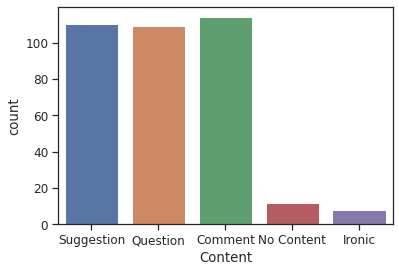

In [334]:
sns.set(style="ticks", font_scale=1.1)
sns.countplot(x='Content', data = r2_df)
plt.savefig('fig/R2/Message.pdf', bbox_inches="tight")

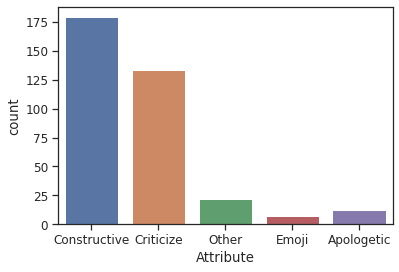

In [335]:
sns.countplot(x='Attribute', data = r2_df)
plt.savefig('fig/R2/Reason.pdf', bbox_inches="tight")

# RQ3 significant of each model compared to RF

In [19]:
lr_p = [0.58562939,0.592543975,0.57022319,0.578878062,0.580305424,0.588785047,0.590021692,0.587862069,0.601649814,0.58720774]
lr_r = [0.602724493,0.617341357,0.586013986,0.612256267,0.611373093,0.608275862,0.61209564,0.604539007,0.614235262,0.601265823]
lr_f1 = [0.59405398,0.604688547,0.57801076,0.595099499,0.595434283,0.598371777,0.600855999,0.596083916,0.607877403,0.594153637]
lr_auroc = [0.61765737,0.616460798,0.598512913,0.612774652,0.60883204,0.612449305,0.630877421,0.622751177,0.621723243,0.609837774]
dt_p = [0.559695174,0.553802817,0.557724958,0.555301515,0.561651747,0.559287383,0.559292549,0.551801173,0.56344025,0.560906516]
dt_r = [0.551292744,0.537746171,0.551328671,0.541225627,0.539528433,0.528275862,0.542616034,0.560567376,0.539255637,0.544854155]
dt_f1 = [0.555462185,0.545656397,0.55450837,0.548173226,0.550367855,0.543339481,0.550828098,0.556149733,0.551082732,0.552763819]
dt_auroc = [0.582455824,0.566656836,0.580147815,0.572011332,0.574386301,0.573527903,0.583608787,0.574821284,0.571716424,0.570701716]
rf_p = [0.619367478,0.631179775,0.614040034,0.615168539,0.611020185,0.626091857,0.618009751,0.617971178,0.63888104,0.620592384]
rf_r = [0.615234918,0.614606127,0.609230769,0.610027855,0.621359223,0.612965517,0.606188467,0.620425532,0.614235262,0.605393506]
rf_f1 = [0.617294282,0.622782705,0.611625948,0.612587413,0.616146335,0.619459158,0.612042034,0.619195923,0.626315789,0.612898732]
rf_auroc = [0.669302779,0.664313595,0.66216938,0.660766087,0.65958562,0.672963675,0.675715112,0.673084459,0.672629885,0.661573518]
svm_p = [0.572028952,0.572280534,0.557067813,0.569025929,0.566015533,0.58062201,0.574074074,0.566857689,0.583556312,0.578348268]
svm_r = [0.681123158,0.656181619,0.652587413,0.678551532,0.667128988,0.669517241,0.680168776,0.673475177,0.651725075,0.657127133]
svm_f1 = [0.621827411,0.611365953,0.601056293,0.61898107,0.612426789,0.621909033,0.622634222,0.615584079,0.615759754,0.615226072]
svm_auroc = [0.620906601,0.610914821,0.603919689,0.616064758,0.606658204,0.615761257,0.629108946,0.621723024,0.618820379,0.613014055]
nb_p = [0.636648395,0.643367752,0.628793774,0.628065395,0.620216606,0.623538012,0.680751174,0.636363636,0.626935711,0.628897338]
nb_r = [0.226021685,0.221553611,0.226013986,0.256824513,0.238280166,0.235310345,0.163150492,0.238297872,0.362944852,0.227572922]
nb_f1 = [0.333606894,0.329603255,0.332510288,0.364570977,0.344288577,0.34167835,0.263217608,0.346749226,0.459738472,0.334208931]
nb_auroc = [0.597526727,0.598281518,0.588577044,0.603516458,0.591753275,0.597642473,0.615290576,0.609125688,0.605222048,0.597124847]
qda_p = [0.598055105,0.587112172,0.615144418,0.623635196,0.603341584,0.583417085,0.581278027,0.609243697,0.622959184,0.637880275]
qda_r = [0.410341952,0.403719912,0.22041958,0.270473538,0.270457698,0.320275862,0.291701828,0.370212766,0.331703341,0.178866263]
qda_f1 = [0.486727123,0.478444084,0.324546952,0.377307169,0.373491668,0.413535174,0.388462259,0.460561143,0.432901968,0.279389641]
qda_auroc = [0.592502492,0.587143103,0.575781976,0.596452308,0.573122084,0.586302692,0.582928875,0.602182507,0.592468452,0.583199534]
knn_p = [0.552092109,0.567606035,0.548340548,0.562091503,0.552009119,0.563278309,0.541607092,0.554573953,0.564044306,0.560745065]
knn_r = [0.546566583,0.545404814,0.531468531,0.55097493,0.537309293,0.536551724,0.532770745,0.552056738,0.539527302,0.555035773]
knn_f1 = [0.549315451,0.556284001,0.539772727,0.556477704,0.544560022,0.54959028,0.537152581,0.553312482,0.551513468,0.557875812]
knn_auroc = [0.56817302,0.573699111,0.563184885,0.573698708,0.56508797,0.570872485,0.566815232,0.58218141,0.568991453,0.570539699]
nn_p = [0.554309587,0.575225806,0.546289915,0.562076749,0.547015536,0.574614537,0.568716781,0.553571429,0.578253297,0.569992061]
nn_r = [0.700861829,0.609682713,0.665174825,0.624233983,0.742302358,0.575724138,0.632067511,0.703546099,0.631350177,0.592735278]
nn_f1 = [0.61903008,0.59195326,0.599899092,0.59152699,0.629869366,0.575168803,0.598721023,0.619612742,0.603636364,0.581141238]
nn_auroc = [0.597146041,0.595599182,0.575477725,0.595715213,0.591768755,0.593459976,0.609431187,0.600672445,0.59865743,0.591807637]
dm_p = [0.50330033,0.513633834,0.505277778,0.508855777,0.503941441,0.506740028,0.498347107,0.484257453,0.509782309,0.506942477]
dm_r = [0.508757298,0.504923414,0.508811189,0.504178273,0.496532594,0.508137931,0.508860759,0.493049645,0.50258082,0.492294992]
dm_f1 = [0.506014102,0.509241379,0.507038328,0.506506226,0.500209585,0.507438017,0.503549061,0.488614001,0.506155951,0.499511378]
dm_auroc = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]

In [23]:
model_target = 'rf'
models = ['lr','dt','svm','nb','qda','knn','nn','dm']
metrics = ['p','r','f1','auroc']
for me in metrics:
    for mo in models:
        print(me,mo)
        pvalue = eval('mannwhitneyu('+model_target+'_'+me+','+mo+'_'+me+')')
        effsize = eval('cliffsDelta('+model_target+'_'+me+','+mo+'_'+me+')')
        print(pvalue,effsize)

p lr
MannwhitneyuResult(statistic=100.0, pvalue=0.00018267179110955002) (1.0, 'large')
p dt
MannwhitneyuResult(statistic=100.0, pvalue=0.00018267179110955002) (1.0, 'large')
p svm
MannwhitneyuResult(statistic=100.0, pvalue=0.00018267179110955002) (1.0, 'large')
p nb
MannwhitneyuResult(statistic=17.0, pvalue=0.014019277113959953) (-0.66, 'large')
p qda
MannwhitneyuResult(statistic=75.0, pvalue=0.06402210128302689) (0.5, 'large')
p knn
MannwhitneyuResult(statistic=100.0, pvalue=0.00018267179110955002) (1.0, 'large')
p nn
MannwhitneyuResult(statistic=100.0, pvalue=0.00018267179110955002) (1.0, 'large')
p dm
MannwhitneyuResult(statistic=100.0, pvalue=0.00018267179110955002) (1.0, 'large')
r lr
MannwhitneyuResult(statistic=72.5, pvalue=0.09617854690583334) (0.45, 'medium')
r dt
MannwhitneyuResult(statistic=100.0, pvalue=0.00018267179110955002) (1.0, 'large')
r svm
MannwhitneyuResult(statistic=0.0, pvalue=0.00018267179110955002) (-1.0, 'large')
r nb
MannwhitneyuResult(statistic=100.0, pvalue

# Feature Importance

In [59]:
final_feature_df = pd.read_csv(os.path.join(exper_dir,'final_feature_df.csv'))
df_x = final_feature_df[['toxic','anger','fear','joy','love', 'sadness', 'surprise', 'sentiment',
       'responsiveness', 'interaction', 'word_first_response', 'merged',
       'other_project_pr', 'other_same_language_pr', 'gh_account_duration', 'project_commit', 'project_pr',
       'language', 'pr_commit','future_contribution']]


emotion = ['anger','fear','joy','love', 'sadness','surprise']
for e in emotion:
    df_x[e] = df_x[e].map(lambda x: 1 if x=='YES' else 0)

df_x['merged'] = df_x['merged'].map(lambda x: 1 if x else 0)

df_x['future_contribution'] = df_x['future_contribution'].map(lambda x: 1 if x>0 else 0)

# from sklearn.preprocessing import OneHotEncoder
# df_x = df_x.reset_index().drop(columns=['index'])
# enc = OneHotEncoder(handle_unknown='ignore')
# enc_df = pd.DataFrame(enc.fit_transform(df_x[['language']]).toarray())
# df_x = df_x.join(enc_df)

programming_langauge = df_x['language'].unique()
programming_langauge_df = pd.DataFrame(programming_langauge, columns=['language'])
dum_df = pd.get_dummies(programming_langauge_df, columns=["language"], prefix=["language"] )
programming_langauge_df = programming_langauge_df.join(dum_df)
df_x = pd.merge(df_x, programming_langauge_df, how='inner', on='language')
df_x.drop(columns=['language'],inplace=True)

df_y = list(df_x['future_contribution'])
df_x.drop(columns=['future_contribution'],inplace=True)
csvdf = df_x
dict_normalize = {}
tempcsv=csvdf.select_dtypes(exclude='object')
for column in tempcsv:
    if tempcsv[column].min() != 0 or tempcsv[column].max() != 1:
        dict_normalize[column] = {}
        dict_normalize[column]['max'] = tempcsv[column].max()
        dict_normalize[column]['min'] = tempcsv[column].min()
        print(column,"\t", tempcsv[column].min(),"\t",tempcsv[column].max())
        csvdf[column] = (csvdf[column] - csvdf[column].min())/(csvdf[column].max()-csvdf[column].min())
dict_normalize
# pickle.dump(dict_normalize, open(outputfilename['norm'], 'wb')) # # # # # # @@@ CHANGE OUTPUT @@@ # # # # # #

# x_df = csvdf.drop(['future_contribution'], axis=1)
# y_df = csvdf['future_contribution']
# pd.to_numeric(y_df)
# y_df = y_df.astype(np.float16)


<ipython-input-59-6bdd35aabff6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x[e] = df_x[e].map(lambda x: 1 if x=='YES' else 0)
<ipython-input-59-6bdd35aabff6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['merged'] = df_x['merged'].map(lambda x: 1 if x else 0)
<ipython-input-59-6bdd35aabff6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

sentiment 	 -4 	 3
responsiveness 	 1.0 	 161647217.0
interaction 	 0 	 1599
word_first_response 	 1 	 167
other_project_pr 	 0.0 	 7949.0
other_same_language_pr 	 0.0 	 1893.0
gh_account_duration 	 0.0 	 408721859.0
project_commit 	 0.0 	 219752.0
project_pr 	 0.0 	 45416.0
pr_commit 	 0.0 	 643.0


{'sentiment': {'max': 3, 'min': -4},
 'responsiveness': {'max': 161647217.0, 'min': 1.0},
 'interaction': {'max': 1599, 'min': 0},
 'word_first_response': {'max': 167, 'min': 1},
 'other_project_pr': {'max': 7949.0, 'min': 0.0},
 'other_same_language_pr': {'max': 1893.0, 'min': 0.0},
 'gh_account_duration': {'max': 408721859.0, 'min': 0.0},
 'project_commit': {'max': 219752.0, 'min': 0.0},
 'project_pr': {'max': 45416.0, 'min': 0.0},
 'pr_commit': {'max': 643.0, 'min': 0.0}}

In [60]:
y_df.value_counts()

NameError: name 'y_df' is not defined

In [61]:
final_feature_df['type2'].value_counts()

Interact        41887
Not-Interact    29549
Name: type2, dtype: int64

In [62]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [63]:
X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, random_state=42)

In [64]:
# categorical_encoder = OneHotEncoder(handle_unknown="ignore")
# numerical_pipe = Pipeline([("imputer", SimpleImputer(strategy="mean"))])
# categorical_columns = ['language']
# # numerical_columns = ['toxic','anger','fear','joy','love', 'sadness', 'surprise', 'sentiment',
# #        'responsiveness', 'interaction', 'word_first_response', 'merged',
# #        'other_project_pr', 'other_same_language_pr', 'gh_account_duration', 'project_commit', 'project_pr', 'pr_commit']
# # preprocessing = ColumnTransformer(
# #     [
# #         ("language", categorical_encoder, categorical_columns),
# #         ("num", numerical_pipe, numerical_columns)
# #     ]
# # )

rf = Pipeline(
    [
#         ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(**{'n_estimators': 1800,'min_samples_split': 2,'min_samples_leaf': 1,'max_features': 'auto','max_depth': 20,'bootstrap': False,'n_jobs':-1})),
    ]
)
rf.fit(df_x,df_y)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=20,
                                        n_estimators=1800, n_jobs=-1))])

In [34]:
# rf.named_steps["classifier"].feature_importances_

In [35]:
# ohe = rf.named_steps["preprocess"].named_transformers_["language"]
# feature_names = ohe.get_feature_names(categorical_columns)
# feature_names = np.r_[feature_names, numerical_columns]

# tree_feature_importances = rf.named_steps["classifier"].feature_importances_
# sorted_idx = tree_feature_importances.argsort()

# y_ticks = np.arange(0, len(feature_names))
# fig, ax = plt.subplots()
# ax.barh(y_ticks, tree_feature_importances[sorted_idx])
# ax.set_yticks(y_ticks)
# ax.set_yticklabels(feature_names[sorted_idx])
# ax.set_title("Random Forest Feature Importances (MDI)")
# fig.tight_layout()
# plt.show()

NameError: name 'x_df' is not defined

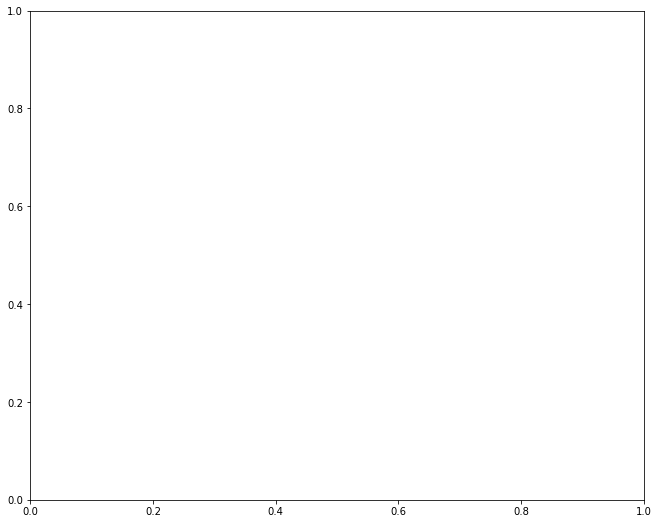

In [14]:
result = permutation_importance(
    rf, X_val,y_val, n_repeats=10, random_state=42
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(11, 9))
plt.rcParams['font.size'] = '20'
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=x_df.columns[sorted_idx]
)
# ax.set_title("Feature Permutation Importances")
fig.tight_layout()
plt.savefig('fig/R3/feature_permutation_importances.pdf')
plt.show()


# pairwise correlation

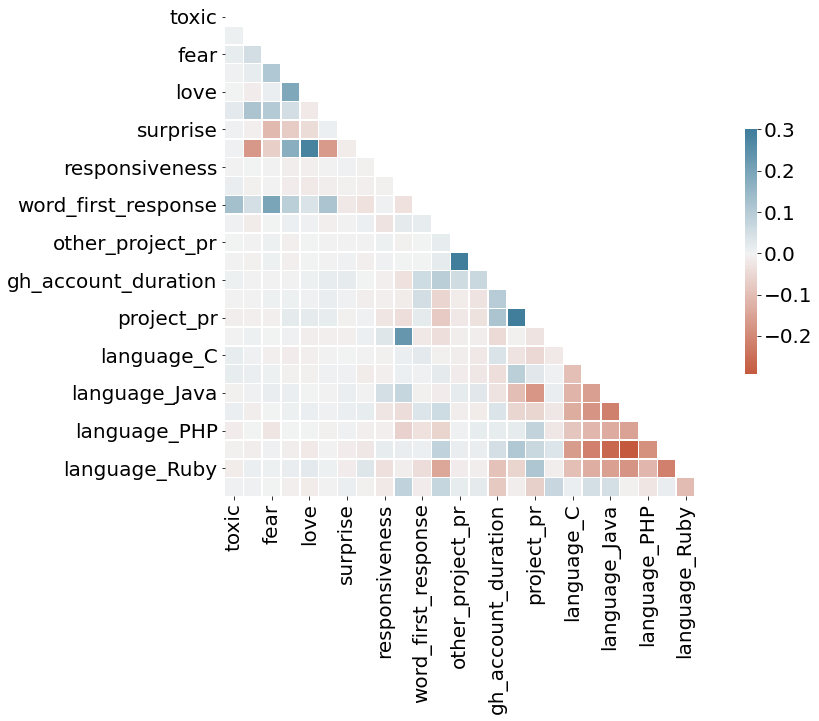

In [37]:
d = df_x.copy(deep=True)
d['future_contribution'] = df_y
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('fig/R3/pairwise_correlation.pdf',bbox_inches="tight")

In [303]:
final_feature_df['surprise'].value_counts()

NO     61903
YES     9533
Name: surprise, dtype: int64

# Partial Independent Plot

In [65]:
from sklearn.inspection import PartialDependenceDisplay

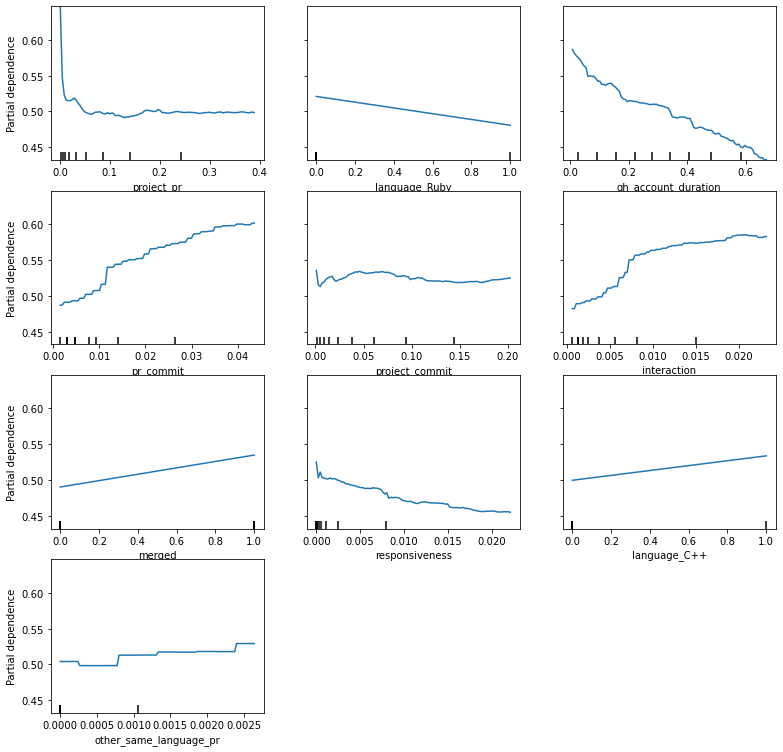

In [73]:
fig, ax = plt.subplots(figsize=(13, 13))
pdp = PartialDependenceDisplay.from_estimator(rf, X_val, ['project_pr','language_Ruby','gh_account_duration','pr_commit','project_commit','interaction','merged','responsiveness','language_C++','other_same_language_pr'],ax=ax)


In [74]:
fig.savefig('fig/R3/pdp.pdf',bbox_inches="tight")